plot facebook data in a 2D Histogramm

In [2]:
# takes around 3mins repending on number of points
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import utm

# read
df = pd.read_csv("pop_ger.csv", sep = ",", names = ["y","x","weight"], dtype = np.float64, skiprows = 1)

# entspricht 33.25 KM Quadrat ziemlich mittig über Leipzig
LONMIN = 51.17887537478123
LATMIN = 12.07755924488432

LONMAX = 51.447979280683676
LATMAX = 12.595976585176572

print("selecting the relevant rows...")
# select rows that are inside of the bounding box
df = df[(df.x >= LATMIN) & (df.x <= LATMAX)]
df = df[(df.y >= LONMIN) & (df.y <= LONMAX)]

print("converting to numpy...")
# convert to numpy
x = df["x"].tolist()
y = df["y"].tolist()
weight = df["weight"].tolist()

selecting the relevant rows...
converting to numpy...


plotting...


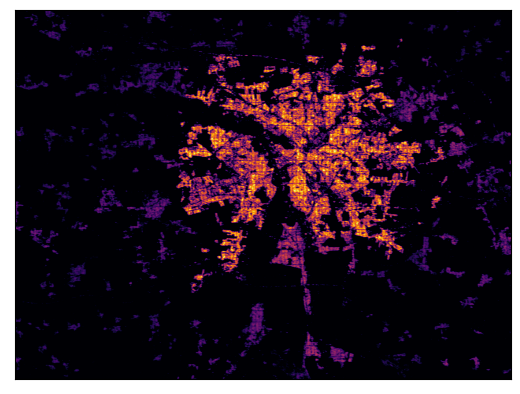

In [52]:
BINS = 1000
BLUR = 1

print("plotting...")

fig, ax = plt.subplots()
data = np.histogram2d(x, y, weights = weight, bins=BINS)[0]
data = gaussian_filter(data, sigma=BLUR)
plt.pcolormesh(data.T, cmap='inferno', shading='gouraud')
ax.set_xticks([])
ax.set_yticks([])
fig.canvas.draw()

Relating everything back to how good each place is connected

Metrics:

- Stop Density
- "Mobility Score"

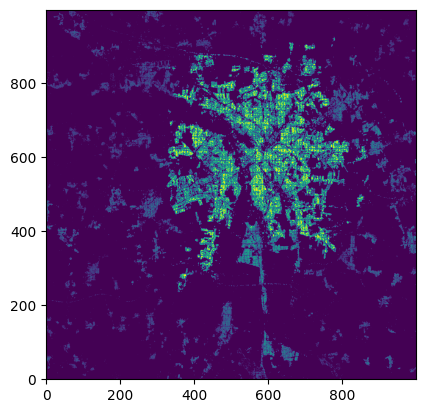

In [68]:

import math as m
import matplotlib.pyplot as plt


GRIDSIZE = 1000

# calculate delta as the range of all possible coorinates. Every coordinate falls in this range
LONDELTA = LONMAX - LONMIN
LATDELTA = LATMAX - LATMIN


POPULATIONGRID = [[0 for i in range(GRIDSIZE)] for j in range (GRIDSIZE)]


l = []
def getindices(lat, lon):


    xind = m.floor(((lat-LATMIN) / (LATMAX - LATMIN)) * GRIDSIZE) # data normalisation to be in the range of 0 - 99
    yind = m.floor(((lon-LONMIN) / (LONMAX - LONMIN)) * GRIDSIZE)

    return [xind,yind]

for x1, y1, w1 in zip(x,y, weight):
    xind, yind = getindices(x1,y1)
    POPULATIONGRID[yind][xind] += w1

# sanity check
plt.imshow(POPULATIONGRID, interpolation = None, origin = "lower")
plt.show()



Read in Neighbours and put them on the same grid

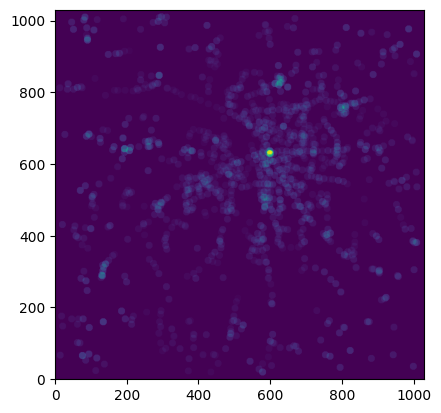

In [69]:
import json
from utils import load_stops_as_dict
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
import numpy as np

all_stops = load_stops_as_dict()

f = open("lvb_auswertung/neighbours_1.json")
nb = json.load(f)

STOPSGRID = [[0 for i in range(GRIDSIZE)] for j in range (GRIDSIZE)] # create grid thats 0-99

for key_stop, nb_list in nb.items():


    w = len(nb_list)
    lat, lon = all_stops[key_stop]

    # convert directly to grid indices 
    xind, yind = getindices(lon, lat)


    # not all stops are inside of the bounding box created earlier
    if (0 <= yind < GRIDSIZE) and (0 <= xind < GRIDSIZE):
        STOPSGRID[yind][xind] += w

# blur the stops because they are "reachable" in a circle around them
BLURREDSTOPSGRID = gaussian_filter(np.array(STOPSGRID), sigma=0)

# the same can be done with a convolution filter
# first create a circluar filter
# then convolve it over every pixel in the image
# pixels that contain (at least) one stop will be turned into a circle
# https://stackoverflow.com/questions/49330080/numpy-2d-array-selecting-indices-in-a-circle

fx = np.arange(0, 32)
fy = np.arange(0, 32)
farr = np.zeros((fy.size, fx.size))

cx = 12.
cy = 16.
r = 10.

mask = (fx[np.newaxis,:]-cx)**2 + (fy[:,np.newaxis]-cy)**2 < r**2
farr[mask] = 123.

kernel = farr
CONVOLVEDSTOPSGRID = convolve2d(STOPSGRID, kernel)


plt.imshow(CONVOLVEDSTOPSGRID, interpolation = None, origin = "lower")
plt.show()

Analyzing both grids
- how many people live withing x meters of a bus stop
- how many people 

In [43]:
# Everything with